<a href="https://colab.research.google.com/github/sarvasvaKhare/BubbleMassTransfer/blob/main/2D_shape_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
from sklearn.preprocessing import MinMaxScaler
import sys
matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
from google.colab import drive
drive.mount('/content/gdrive')

Pandas version: 1.3.5
Numpy version: 1.21.6
PyTorch version: 1.13.1+cu116
Mounted at /content/gdrive


In [2]:
data_file_cap = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/bhaga_03_l16.csv"
data_file_eli = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/water_05_l16.csv"

data_cap = pd.read_csv(data_file_cap, header=0)
data_eli = pd.read_csv(data_file_eli, header=0)
print("The spherical cap data set contains {} points.".format(data_cap.shape[0]))
print("The ellipse data set contains {} points.".format(data_eli.shape[0]))
data_eli.head()

The spherical cap data set contains 1170 points.
The ellipse data set contains 1250 points.


,px,py
0,-0.339129,0.000000
1,-0.339129,0.007324
2,-0.339129,0.007324
3,-0.339029,0.014648
4,-0.339029,0.014648


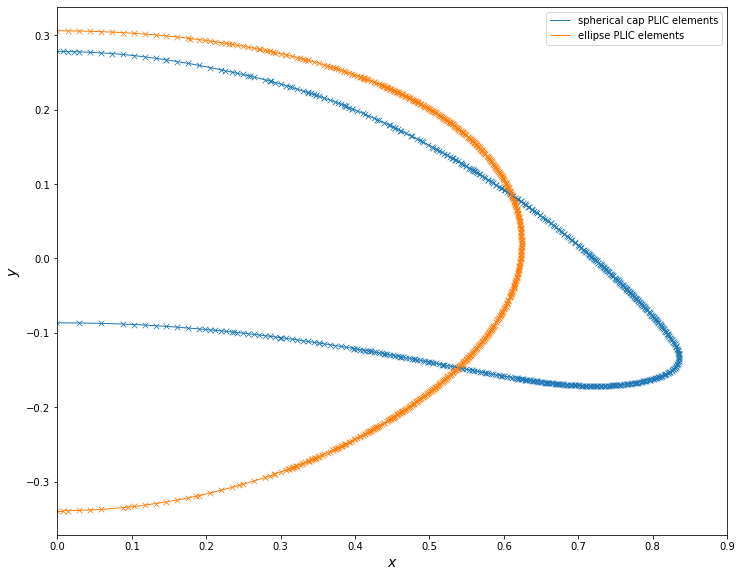

In [3]:
%matplotlib inline
# uncomment for interactive plot
# %matplotlib notebook
    
fontsize = 14

fig, ax = plt.subplots(1, figsize=(12, 10))

line_segments_cap = [[(data_cap.py[i], data_cap.px[i]),(data_cap.py[i+1], data_cap.px[i+1])]
                     for i in range(0, data_cap.shape[0] - 1, 2) ]
lc_cap = mc.LineCollection(line_segments_cap, linewidths=1, colors='C0', label=r"spherical cap PLIC elements")
ax.add_collection(lc_cap)
line_segments_eli = [[(data_eli.py[i], data_eli.px[i]),(data_eli.py[i+1], data_eli.px[i+1])]
                     for i in range(0, data_eli.shape[0] - 1, 2) ]
lc_eli = mc.LineCollection(line_segments_eli, linewidths=1, colors='C1', label=r"ellipse PLIC elements")
ax.add_collection(lc_eli)

ax.autoscale()

x = [i[0] for j in line_segments_cap for i in j]
y = [i[1] for j in line_segments_cap for i in j]
ax.scatter(x, y, marker='x', color='C0', s=30, linewidth=0.5)
x = [i[0] for j in line_segments_eli for i in j]
y = [i[1] for j in line_segments_eli for i in j]
ax.scatter(x, y, marker='x', color='C1', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.legend()
plt.show()

In [4]:
def polar_coordinates(px, py):
    '''Converts radius from Cartesian coordinates r(x,y) to polar coordinates r(phi).
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

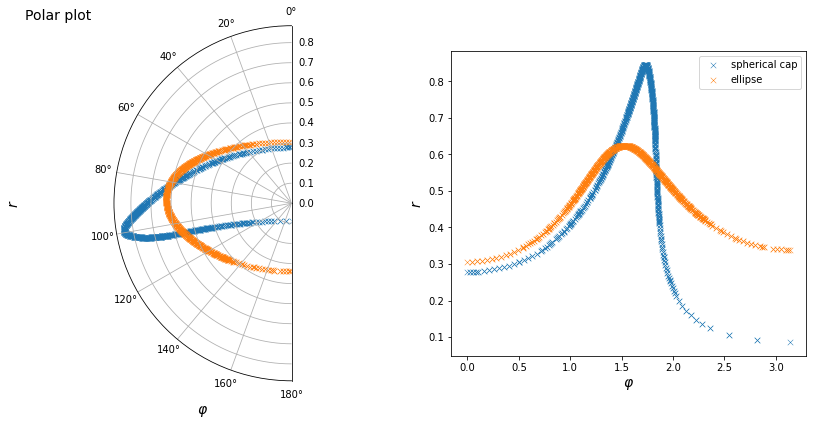

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius_cap, phi_cap = polar_coordinates(data_cap.py.values, data_cap.px.values)
radius_eli, phi_eli = polar_coordinates(data_eli.py.values, data_eli.px.values)

ax1.set_theta_zero_location("N")
ax1.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5)
ax1.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax2.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5, label=r"ellipse")
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
ax2.legend()
    
plt.show()

In [6]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [7]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None, verbose=100):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    verbose - Integer : defines frequency for loss information output
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    #training loop
    best_loss = 1.0E5
    count = 0
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            count += 1
            best_loss = loss.item()
            if count % verbose == 0:
                print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            if path is not None:
                if count % verbose == 0: print("Saving model as {}".format(path))
                torch.save(model.state_dict(), path)
    return model.eval()

In [8]:
radius_model_cap_direct = SimpleMLP(n_layers=6, n_neurons=40)
phi_cap = phi_cap.astype('float32')
radius_cap = radius_cap.astype('float32')
radius_model_cap_direct = approximate_function(phi_cap, radius_cap, radius_model_cap_direct, max_iter=1500,
                                               l_rate=0.01, path="/content/gdrive/My Drive/radius_model_cap_direct.pt")

Loss/max. dev. decreased in epoch 203: 0.02327117510139942/0.5746145844459534
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 303: 0.02110651694238186/0.5884531736373901
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 403: 0.008999457582831383/0.3621440827846527
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 552: 0.00012453609087970108/0.08166792243719101
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 718: 0.00010968726564897224/0.07446946948766708
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 889: 9.834681259235367e-05/0.06503551453351974
Saving model as /content/gdrive/My Drive/radius_model_cap_direct.pt
Loss/max. dev. decreased in epoch 1060: 8.67923881742172e-05/0.054662562906742096
Saving model as /content/gdriv

In [9]:
radius_model_eli_direct = SimpleMLP(n_layers=6, n_neurons=40)
phi_eli = phi_eli.astype('float32')
radius_eli = radius_eli.astype('float32')
radius_model_eli_direct = approximate_function(phi_eli, radius_eli, radius_model_eli_direct, max_iter=1500,
                                               l_rate=0.01, path="/content/gdrive/My Drive/radius_model_eli_direct.pt")

Loss/max. dev. decreased in epoch 231: 0.0062773446552455425/0.22245270013809204
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 331: 0.0054111173376441/0.19685065746307373
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 431: 0.001851355191320181/0.16489672660827637
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 568: 2.424345098006597e-07/0.002015143632888794
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 826: 1.491098942096869e-07/0.001708686351776123
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 1046: 1.1326253002152953e-07/0.001622021198272705
Saving model as /content/gdrive/My Drive/radius_model_eli_direct.pt
Loss/max. dev. decreased in epoch 1261: 9.396366351666074e-08/0.00160980224609375
Saving model as /conten

Maximum relative deviation for spherical cap: 41.89% at angle 3.14.
Maximum relative deviation for ellipse: 0.55% at angle 1.71.


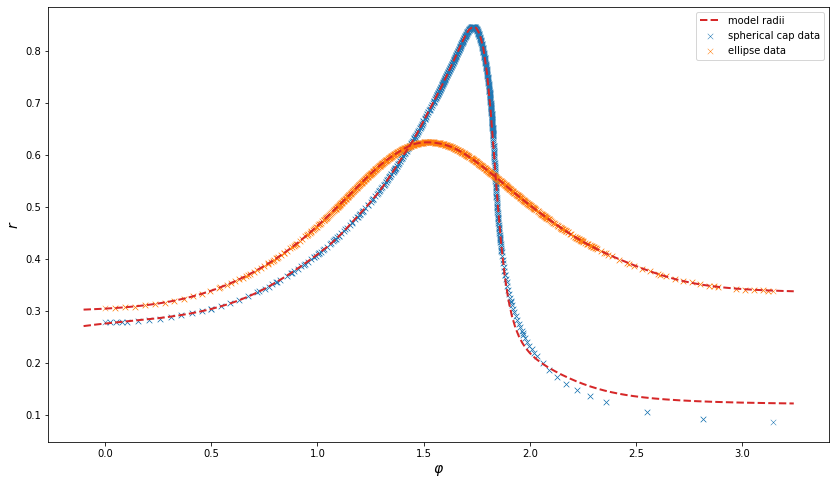

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
radius_model_cap_direct.load_state_dict(torch.load("/content/gdrive/My Drive/radius_model_cap_direct.pt"))
phi_tensor1=phi_tensor.to(torch.float)
model_radius_cap = radius_model_cap_direct.forward(phi_tensor1).detach().squeeze().numpy()
radius_model_eli_direct.load_state_dict(torch.load("/content/gdrive/My Drive/radius_model_eli_direct.pt"))
model_radius_eli = radius_model_eli_direct.forward(phi_tensor1).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_cap_tensor = torch.from_numpy(phi_cap).unsqueeze_(-1)
phi_eli_tensor = torch.from_numpy(phi_eli).unsqueeze_(-1)
model_radius_cap_data = radius_model_cap_direct.forward(phi_cap_tensor).detach().squeeze().numpy()
model_radius_eli_data = radius_model_eli_direct.forward(phi_eli_tensor).detach().squeeze().numpy()
diff_cap = np.absolute(model_radius_cap_data - radius_cap)
diff_eli = np.absolute(model_radius_eli_data - radius_eli)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation for spherical cap: {:2.2f}% at angle {:2.2f}.".format(
      np.amax(diff_cap)/radius_cap[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation for ellipse: {:2.2f}% at angle {:2.2f}.".format(
      np.amax(diff_eli)/radius_eli[max_pos_eli] * 100, phi_cap[max_pos_eli]))

ax.plot(eval_phi, model_radius_cap, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, model_radius_eli, linewidth=2, linestyle="--", c='C3')

ax.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"spherical cap data")
ax.scatter(phi_eli, radius_eli, marker='x', color='C1', s=30, linewidth=0.5, label=r"ellipse data")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend()
plt.show()

USING DOMAIN KNOWLEDGE

In [11]:
from scipy.special import expit

def ellipse_radius(phi, a, b):
    '''Compute the radius of an ellipse.
      
    Parameters
    ----------
    phi - array-like : polar angle
    a - Float        : long half axis length
    b - Float        : short half axis length
    
    Returns
    -------
    radius - array-like : ellipse radius
    
    '''
    return a * b / np.sqrt(np.square(a * np.cos(phi)) + np.square(b * np.sin(phi)))


def spherical_cap_radius(phi, a, b, h, phi_max, R_max):
    '''Compute the radius of a spherical cap w.r.t. the cap center.
      
    Parameters
    ----------
    phi - array-like : polar angle w.r.t. to cap center
    a - Float        : half axis length of the cap
    b - Float        : distance between cap center and bottom
    h - Float        : cap height
    phi_max - Float  : polar angle of R_max
    R_max - Float    : maximum radius of the cap w.r.t. its center
    
    Returns
    -------
    radius - array-like : spherical cap radius
    
    '''
    R_cap = (a**2 + h**2) / (2 * h)
    h_1 = h - b
    term_1 = np.cos(phi) * (h_1 - R_cap)
    term_2 = np.square(np.cos(phi) * (R_cap - h_1)) - h_1 * (h_1 - 2.0 * R_cap)
    R_1 = term_1 + np.sqrt(term_2)
    R_2 = np.minimum(b / np.cos(np.pi - phi), np.ones(len(phi)) * R_max)
    R_2 = np.where(R_2 > 0, R_2, R_max)
    return np.minimum(R_1, R_2)

In [12]:
long_axis_cap = abs(np.amax(data_cap.py.values) - np.amin(data_cap.py.values))
height_cap = abs(np.amax(data_cap.px.values) - np.amin(data_cap.px.values))
offset = abs(np.amin(data_cap.px.values))
phi_max = phi_cap[np.argmax(radius_cap)]
R_max = np.amax(radius_cap)
radius_cap_simple = spherical_cap_radius(phi_cap, long_axis_cap, offset, height_cap, phi_max, R_max)
# simple approximation of ellipse
long_axis_eli = abs(np.amax(data_eli.py.values) - np.amin(data_eli.py.values))
short_axis_eli = abs(np.amax(data_eli.px.values) - np.amin(data_eli.px.values)) * 0.5
radius_eli_simple = ellipse_radius(phi_eli, long_axis_eli, short_axis_eli)
# rescaling of the original radii
radius_cap_scaled = radius_cap / radius_cap_simple
radius_eli_scaled = radius_eli / radius_eli_simple
scaler_cap = MinMaxScaler()
scaler_eli = MinMaxScaler()
radius_cap_scaled_01 = np.squeeze(scaler_cap.fit_transform(radius_cap_scaled.reshape(-1,1)))
radius_eli_scaled_01 = np.squeeze(scaler_eli.fit_transform(radius_eli_scaled.reshape(-1,1)))

In [13]:
print("Spherical cap data:")
print("-" * len("Spherical cap data:"))
print("The relative variance of the original radius is {:1.4f}.".format(np.var(radius_cap) / np.mean(radius_cap)))
print("The relative variance of the scaled radius is {:1.4f}.".format(np.var(radius_cap_scaled) / np.mean(radius_cap_scaled)))
print("\nEllipse data:")
print("-" * len("Ellipse data:"))
print("The relative variance of the original radius is {:1.4f}.".format(np.var(radius_eli) / np.mean(radius_eli)))
print("The relative variance of the scaled radius is {:1.4f}.".format(np.var(radius_eli_scaled) / np.mean(radius_eli_scaled)))

Spherical cap data:
-------------------
The relative variance of the original radius is 0.0489.
The relative variance of the scaled radius is 0.0162.

Ellipse data:
-------------
The relative variance of the original radius is 0.0119.
The relative variance of the scaled radius is 0.0004.


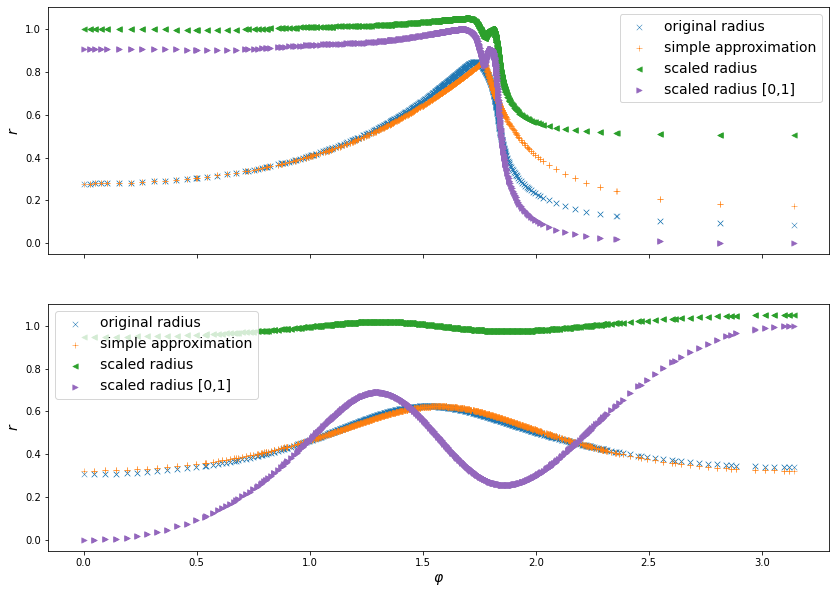

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)
ax1.scatter(phi_cap, radius_cap, marker='x', color='C0', s=30, linewidth=0.5, label=r"original radius")
ax1.scatter(phi_cap, radius_cap_simple, marker='+', color='C1', s=30, linewidth=0.5, label=r"simple approximation")
ax1.scatter(phi_cap, radius_cap_scaled, marker='<', color='C2', s=30, linewidth=0.5, label=r"scaled radius")
ax1.scatter(phi_cap, radius_cap_scaled_01, marker='>', color='C4', s=30, linewidth=0.5, label=r"scaled radius [0,1]")
ax1.set_ylabel(r"$r$", fontsize=fontsize)
ax1.legend(fontsize=fontsize)

ax2.scatter(phi_eli, radius_eli, marker='x', color='C0', s=30, linewidth=0.5, label=r"original radius")
ax2.scatter(phi_eli, radius_eli_simple, marker='+', color='C1', s=30, linewidth=0.5, label=r"simple approximation")
ax2.scatter(phi_eli, radius_eli_scaled, marker='<', color='C2', s=30, linewidth=0.5, label=r"scaled radius")
ax2.scatter(phi_eli, radius_eli_scaled_01, marker='>', color='C4', s=30, linewidth=0.5, label=r"scaled radius [0,1]")
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.show()

In [15]:
radius_model_cap_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_cap_scaled_01 = radius_cap_scaled_01.astype('float32')
radius_model_cap_scaled = approximate_function(phi_cap, radius_cap_scaled_01, radius_model_cap_scaled, max_iter=1500,
                                           l_rate=0.01, path="/content/gdrive/My Drive/radius_model_cap_scaled.pt")

Loss/max. dev. decreased in epoch 237: 0.052586425095796585/0.8403403759002686
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 337: 0.05257050320506096/0.8401121497154236
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 439: 0.011280292645096779/0.48588573932647705
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 586: 0.0012874649837613106/0.1079484224319458
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 686: 0.0011234275298193097/0.10647112131118774
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 786: 0.0010687727481126785/0.10537290573120117
Saving model as /content/gdrive/My Drive/radius_model_cap_scaled.pt
Loss/max. dev. decreased in epoch 886: 0.0010214891517534852/0.10206562280654907
Saving model as /content/gdrive/

In [17]:
radius_model_eli_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_cap_scaled_01 = radius_cap_scaled_01.astype('float32')
radius_model_eli_scaled = approximate_function(phi_eli, radius_eli_scaled_01, radius_model_eli_scaled, max_iter=1500,
                                           l_rate=0.01, path="/content/gdrive/My Drive/radius_model_eli_scaled.pt")

Loss/max. dev. decreased in epoch 375: 0.03417537361383438/0.5321933031082153
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 475: 0.034116826951503754/0.5318396091461182
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 606: 0.013518036343157291/0.6180610060691833
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 771: 1.1438393812568393e-05/0.018203139305114746
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 871: 5.386192242440302e-06/0.013212516903877258
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 1072: 2.916345238190843e-06/0.00873655080795288
Saving model as /content/gdrive/My Drive/radius_model_eli_scaled.pt
Loss/max. dev. decreased in epoch 1345: 2.1905507310293615e-06/0.00794219970703125
Saving model as /content/g

Maximum relative deviation sherical cap: 6.37% at angle 1.77.
Maximum relative deviation ellipse: 0.72% at angle 2.97.


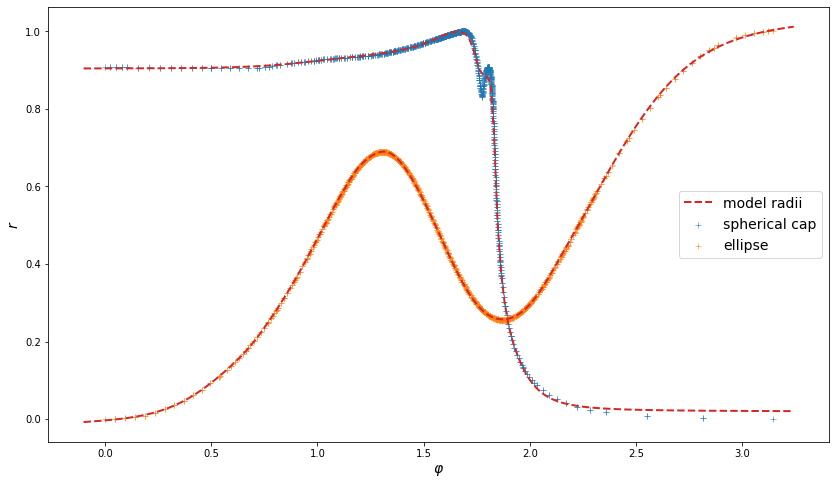

In [21]:
radius_model_cap_scaled.load_state_dict(torch.load("/content/gdrive/My Drive/radius_model_cap_scaled.pt"))
phi_tensor1=phi_tensor.to(torch.float)
model_radius_cap = radius_model_cap_scaled.forward(phi_tensor1).detach().squeeze().numpy()
radius_model_eli_scaled.load_state_dict(torch.load("/content/gdrive/My Drive/radius_model_eli_scaled.pt"))
model_radius_eli = radius_model_eli_scaled.forward(phi_tensor1).detach().squeeze().numpy()

# evaluate maximum relative deviation
model_radius_cap_data = radius_model_cap_scaled.forward(phi_cap_tensor).detach().squeeze().numpy()
model_radius_eli_data = radius_model_eli_scaled.forward(phi_eli_tensor).detach().squeeze().numpy()
diff_cap = np.absolute(model_radius_cap_data - radius_cap_scaled_01)
diff_eli = np.absolute(model_radius_eli_data - radius_eli_scaled_01)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation sherical cap: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_cap)/radius_cap_scaled[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation ellipse: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_eli)/radius_eli_scaled[max_pos_eli] * 100, phi_eli[max_pos_eli]))

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(eval_phi, model_radius_cap, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, model_radius_eli, linewidth=2, linestyle="--", c='C3')
ax.scatter(phi_cap, radius_cap_scaled_01, marker='+', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax.scatter(phi_eli, radius_eli_scaled_01, marker='+', color='C1', s=30, linewidth=0.5, label="ellipse")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()


Maximum relative deviation sherical cap: 3.48% at angle 1.77.
Maximum relative deviation ellipse: 0.07% at angle 2.97.


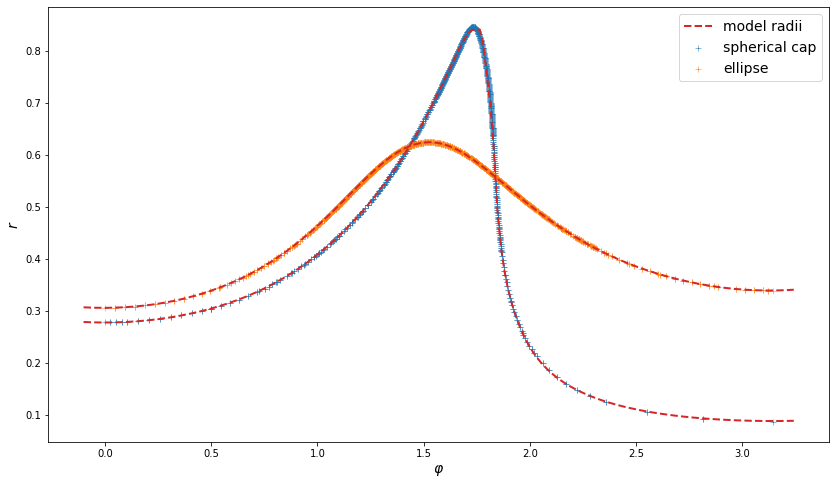

In [22]:
cap_radius_scaled = np.squeeze(scaler_cap.inverse_transform(model_radius_cap.reshape(-1, 1)))
eli_radius_scaled = np.squeeze(scaler_eli.inverse_transform(model_radius_eli.reshape(-1, 1)))
cap_radius_final = cap_radius_scaled * spherical_cap_radius(eval_phi, long_axis_cap, offset, height_cap, phi_max, R_max)
eli_radius_final = eli_radius_scaled * ellipse_radius(eval_phi, long_axis_eli, short_axis_eli)
# pointwise comparison
cap_radius_data_scaled = np.squeeze(scaler_cap.inverse_transform(model_radius_cap_data.reshape(-1, 1)))
eli_radius_data_scaled = np.squeeze(scaler_eli.inverse_transform(model_radius_eli_data.reshape(-1, 1)))
final_cap_data_model = cap_radius_data_scaled * radius_cap_simple
final_eli_data_model = eli_radius_data_scaled * radius_eli_simple
diff_cap = np.absolute(radius_cap - final_cap_data_model)
diff_eli = np.absolute(radius_eli - final_eli_data_model)
max_pos_cap = np.argmax(diff_cap)
max_pos_eli = np.argmax(diff_eli)
print(r"Maximum relative deviation sherical cap: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_cap)/radius_cap[max_pos_cap] * 100, phi_cap[max_pos_cap]))
print(r"Maximum relative deviation ellipse: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff_eli)/radius_eli[max_pos_eli] * 100, phi_eli[max_pos_eli]))

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(eval_phi, cap_radius_final, linewidth=2, linestyle="--", c='C3', label=r"model radii")
ax.plot(eval_phi, eli_radius_final, linewidth=2, linestyle="--", c='C3')
ax.scatter(phi_cap, radius_cap, marker='+', color='C0', s=30, linewidth=0.5, label=r"spherical cap")
ax.scatter(phi_eli, radius_eli, marker='+', color='C1', s=30, linewidth=0.5, label="ellipse")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()